* **StandardScaler**: for features that have normal distribution. Standardization: rescalling the distribution values so that the mean of observed values is 0 and std=1
* **MinMaxScaler**: when upper and lower boundaries are well known. Normalization, is rescaling the data to lay in [0,1] range

Overlap takes 0.6 sec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# https://www.kaggle.com/code/mineshjethva/timeseries-anomaly-detection-using-rnn-autoencoder/notebook
# https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from pickle import dump
from sklearn.metrics import classification_report,average_precision_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score, confusion_matrix, auc

In [ ]:
# df_original = pd.read_csv('/content/drive/MyDrive/200_episodes_robot.csv')
# df_original = pd.read_csv('/content/drive/MyDrive/350_data.csv')
df_original = pd.read_csv('/content/drive/MyDrive/thesis_training/training_spiral.csv')

In [ ]:
feature_list = ['Fx','Fy','Fz','Mx','My']
TIMESTEP = 50
preprocess = True
use_new_features = True

In [ ]:
print(df_original.columns)
print()
print(df_original.shape)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 't', 'x', 'y', 'z', 'rx',
       'ry', 'rz', 'vx', 'vy', 'vz', 'Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz',
       'Case'],
      dtype='object')

(357823, 20)


In [ ]:

df_original.shape

(357823, 20)

5917


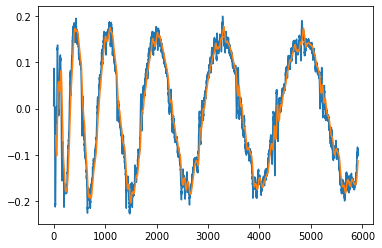

In [ ]:
df_testing = pd.read_csv('/content/drive/MyDrive/spiral4/ep1.csv')
print(len(df_testing))
df_testing.Mx.plot()
df_testing.Mx.rolling(40).mean().plot()
# df_testing.iloc[::50].Mx.plot()
plt.show()

## 1. Select the desired features

In [ ]:
# df_original = df_original.iloc[::10]

In [ ]:
df_original.shape

(357823, 20)

In [ ]:
# verify we do not have anomalies
df_original.Case.value_counts()

False    357823
Name: Case, dtype: int64

In [ ]:
# extract only features that interest us + add dimention for window
df_train = df_original[feature_list]
df_unprocessed = df_original[feature_list]

print('Training shape before adding dimension:',df_train.shape)

Training shape before adding dimension: (357823, 5)


### (Optional) Feature Engineering

In [ ]:
df_train.shape

(357823, 5)

In [ ]:
def new_features(df):
  Fxy = np.linalg.norm(df[['Fx','Fy']].values,axis=1).tolist()
  Mxy = np.linalg.norm(df[['Mx','My']].values,axis=1).tolist()
  theta_Fxy = np.arctan2(df['Fy'], df['Fx']).tolist()
  theta_Mxy = np.arctan2(df['My'], df['Mx']).tolist()
  df.insert(2, "Fxy", Fxy, True)
  df.insert(3, "Mxy", Mxy, True)
  df.insert(4, "theta_Fxy", theta_Fxy, True)
  df.insert(5, "theta_Mxy", theta_Mxy, True)
  df = df[['Fxy','theta_Fxy','Fz','Mxy','theta_Mxy']]
  return df

In [ ]:
if use_new_features:
  mod_features = ["Fxy", "theta_Fxy", "Fz", "Mxy", "theta_Mxy"]
  print('Using new features')
  df_train = new_features(df_train)

Using new features


In [ ]:
df_train.head()

,Fxy,theta_Fxy,Fz,Mxy,theta_Mxy
0,1.834145,-2.203308,5.263730,0.178039,2.412916
1,2.074153,-2.135795,5.207963,0.176010,2.357505
2,2.248978,-2.146450,5.166040,0.171918,2.401702
3,2.205405,-2.095297,5.227640,0.177875,2.410321
4,1.728290,-2.070017,5.529698,0.188909,2.467477


## 2. Preprocessing of the Data
* Smoothing using moving average
* Normalizing features between `[-1,1]` of the non-anomaly (training) data

In [ ]:
# df_train.theta_Fxy.loc[:400].plot()
# df_train.theta_Fxy.loc[:400].rolling(10).mean().plot()


In [ ]:
if preprocess:
    # # create directory (if doesnt exist)
    # directory_path = './scaler/'
    # if not os.path.exists(directory_path):
    #     os.makedirs(directory_path)
    #     print('Created Directory')
    # else:
    #     print('Directory already exists!')
    
    window = 40
    df_train = df_train.rolling(window).mean()
    # due to the moving average we the first (window-1) rows become NaN so we remove them
    df_train = df_train.loc[window-1:]
    print('Before Normalizing')
    # display(df_train.describe())
    # scaler = MinMaxScaler(feature_range=(-1,1))
    # scaler = scaler.fit(df_train)
    # names = df_train.columns
    # df_train[names] = scaler.transform(df_train[names])
    # print('After Normalizing')
    # display(df_train.describe())
    # # save_path = os.path.join(directory_path,'Normalizing_window30.pkl')
    # dump(scaler, open('100_spiral_MinMax.pkl','wb'))
    # print('Saved Scaler!')

    # print out the shape
    print(df_train.shape)

Before Normalizing
(357784, 5)


In [ ]:
# df_train.Fxy.loc[:400].plot()


### 1.1. Create Sequence out of training data

In [ ]:
# we set the data in a window form, in case of timestep = 5
# i=0: X_0=[x(0)..x(5)], y=x(6)
def to_sequence(data, timesteps=1):
    n_features=data.shape[2]
    seq = []
    for i in range(len(data)-timesteps):
        # takes a window of data of specified timesteps
        temp = data[i:(i+timesteps)]
        temp = temp.reshape(timesteps, n_features)
        seq.append(temp)
        
    return np.array(seq)

def to_nooverlap_sequence(data, timesteps=1):
    x = []
    for i in np.arange(0,len(data)-1,timesteps):
        _x = data[i:i+timesteps]
#         print(_x)
        x.append(_x)
        
    return np.array(x)

In [ ]:
print(df_train.shape)


(357784, 5)


In [ ]:
# 90% is training data
train_size = int(len(df_train)*0.9)
rest = len(df_train) - train_size

train, rest = df_train.iloc[:train_size], df_train.iloc[train_size:]

In [ ]:
print(train.shape)
print(rest.shape)

(322005, 5)
(35779, 5)


In [ ]:
# test_size = int(len(rest)*0.5)
# valid_size = len(rest) - test_size

# test, valid = rest.iloc[:test_size], rest.iloc[test_size:]

# print('Test size:',test.shape)
# print('Validation size', valid.shape)

In [ ]:
# train
train = np.expand_dims(train, axis=1)
x_train = to_sequence(train, timesteps=TIMESTEP)
# validation
rest = np.expand_dims(rest, axis=1)
x_valid = to_sequence(rest, timesteps=TIMESTEP)
# test
# valid = np.expand_dims(valid, axis=1)
# x_valid = to_sequence(valid, timesteps=TIMESTEP)
# print
print(x_train.shape)
# print(x_test.shape)
print(x_valid.shape)

(321955, 50, 5)
(35729, 50, 5)



#### Make sure the dimensions fit the LSTM structure:

LSTM layers work on 3D data with the following structure `(sequence, timestep, feature)`.

* **sequence**: Number of samples in the data.
* **timestep**: how many timesteps (window of data) does each sequence/ sample have - after reshaping
* **feature**: how many features does our data have at each timestep




## 3. Building LSTM Autoencoder

### Training model -> stateless

In [ ]:
def repeat(x_inp):
    x, inp = x_inp
    x = tf.expand_dims(x,1)
    x = tf.repeat(x, [tf.shape(inp)[1]],axis=1)
    return x

n_features = x_train.shape[2]

input_layer = keras.layers.Input(shape=(None, n_features))
lstm1 = keras.layers.LSTM(units=64, activation='tanh', name='LSTM_1', return_sequences=False)(input_layer)
dropout1 = keras.layers.Dropout(0.1)(lstm1)

code = keras.layers.Lambda(repeat)([dropout1, input_layer])

lstm3 = keras.layers.LSTM(units=64, activation='tanh', name='LSTM_2', return_sequences=True)(code)
out = keras.layers.TimeDistributed(keras.layers.Dense(units=n_features))(lstm3)


model = keras.Model(input_layer, outputs=out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 5)]    0           []                               
                                                                                                  
 LSTM_1 (LSTM)                  (None, 64)           17920       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 64)           0           ['LSTM_1[0][0]']                 
                                                                                                  
 lambda (Lambda)                (None, None, 64)     0           ['dropout[0][0]',                
                                                                  'input_1[0][0]']            

## 3. Training Model

In [ ]:
# define early stopping to prevent overfit
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                               patience=10, 
                                               mode="min", 
                                               verbose=1,
                                               restore_best_weights=True)

In [ ]:
# we train autoencoder, so both train data and labels are equal to x_train
history = model.fit(x_train, x_train,
            epochs=200,
            batch_size=512,
            validation_data=(x_valid, x_valid),
            callbacks=[early_stopping],
            verbose=True)

Epoch 1/200
629/629 [==============================] - 22s 19ms/step - loss: 0.1599 - val_loss: 0.0404
Epoch 2/200
629/629 [==============================] - 11s 17ms/step - loss: 0.0464 - val_loss: 0.0328
Epoch 3/200
629/629 [==============================] - 11s 17ms/step - loss: 0.0400 - val_loss: 0.0290
Epoch 4/200
629/629 [==============================] - 11s 17ms/step - loss: 0.0371 - val_loss: 0.0272
Epoch 5/200
629/629 [==============================] - 11s 17ms/step - loss: 0.0346 - val_loss: 0.0245
Epoch 6/200
629/629 [==============================] - 11s 18ms/step - loss: 0.0263 - val_loss: 0.0106
Epoch 7/200
629/629 [==============================] - 11s 18ms/step - loss: 0.0138 - val_loss: 0.0065
Epoch 8/200
629/629 [==============================] - 11s 18ms/step - loss: 0.0103 - val_loss: 0.0053
Epoch 9/200
629/629 [==============================] - 11s 18ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 10/200
629/629 [==============================] - 11s 17ms/step - l

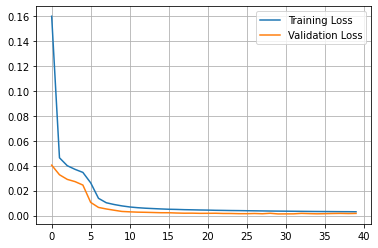

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.grid()
plt.legend()
plt.show()

In [ ]:
model.save('AfterThesis8')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 5)]    0           []                               
                                                                                                  
 LSTM_1 (LSTM)                  (None, 64)           17920       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 64)           0           ['LSTM_1[0][0]']                 
                                                                                                  
 lambda (Lambda)                (None, None, 64)     0           ['dropout[0][0]',                
                                                                  'input_1[0][0]']            

In [ ]:
#  !zip -r AfterThesis8.zip AfterThesis8/ 

  adding: AfterThesis8/ (stored 0%)
  adding: AfterThesis8/variables/ (stored 0%)
  adding: AfterThesis8/variables/variables.index (deflated 62%)
  adding: AfterThesis8/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: AfterThesis8/saved_model.pb (deflated 90%)
  adding: AfterThesis8/assets/ (stored 0%)
  adding: AfterThesis8/fingerprint.pb (stored 0%)
  adding: AfterThesis8/keras_metadata.pb (deflated 89%)


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/thesis_training/AfterThesis6')
# model = keras.models.load_model('Lstm_200data_withConv_5features_30lstm_NoneLayersFinal')
# model = keras.models.load_model('Lstm_200data_withConv_5features_50lstm_NoneLayersFinal')
# Lstm_200data_NoConv_5features_50lstm_NoneLayersFinal_Smoothed

In [ ]:
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 5)]    0           []                               
                                                                                                  
 LSTM_1 (LSTM)                  (None, 64)           17920       ['input_5[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 64)           0           ['LSTM_1[0][0]']                 
                                                                                                  
 lambda_4 (Lambda)              (None, None, 64)     0           ['dropout_4[0][0]',              
                                                                  'input_5[0][0]']          

## 4. Finding threshold (on normal/train data)
1. Find MAE loss on training samples (normal data) 
2. Find max MAE loss value. This is worst the model has performed trying to reconstruct a sample. We will make this a `threshold` for anomaly detection.
3. If `reconstruction_loss > threshold` then model is seeing a pattern its not familiar with, therefore will be labeled as **anomaly**

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

10062/10062 [==============================] - 41s 4ms/step


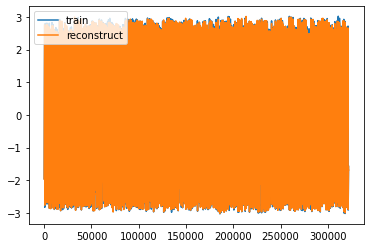

In [ ]:
plt.figure()
plt.plot(x_train[:,1,1],label='train')
plt.plot(x_train_pred[:,1,1],label='reconstruct')
plt.legend()
plt.show()

In [ ]:
print(x_train.shape)
print(x_train_pred.shape)

(321955, 50, 5)
(321955, 50, 5)


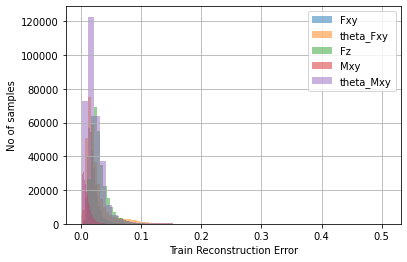

Reconstruction error #1 0.14266792305164488
Reconstruction error #2 0.25511093499910503
Reconstruction error #3 0.27209656676361876
Reconstruction error #4 0.05406502523990801
Reconstruction error #5 0.5062460031645604


In [ ]:
if use_new_features:
  feature_list = mod_features

for loss in range(train_mae_loss.shape[1]):
    plt.hist(train_mae_loss[:,loss], bins=50, label=f"{feature_list[loss]}",alpha=0.5)
plt.xlabel("Train Reconstruction Error")
plt.ylabel("No of samples")
plt.grid()
plt.legend()
plt.show()

thresholds = []
for loss in range(train_mae_loss.shape[1]):
#     temp_threshold = np.mean(train_mae_loss[:,loss]) + np.std(train_mae_loss[:,loss])
    temp_threshold = np.max(train_mae_loss[:,loss])
    thresholds.append(temp_threshold)
    print(f'Reconstruction error #{loss+1}',temp_threshold)
    

We find threshold on **normal** data, we then choose the maximal reconstruction loss and set it to be our threshold. As this is the worst that our model did trying to reconstruct the training data. 
* `reconstruction_loss < threshold `: **normal**
* `reconstruction_loss > threshold `: **anomaly**

In [ ]:
print('thresholds=',thresholds)

thresholds= [0.14266792305164488, 0.25511093499910503, 0.27209656676361876, 0.05406502523990801, 0.5062460031645604]


In [ ]:
max(thresholds)

0.5062460031645604

## 5. Visualizing Reconstruction of the Time-Series 

In [ ]:
x_train.shape

(321955, 50, 5)

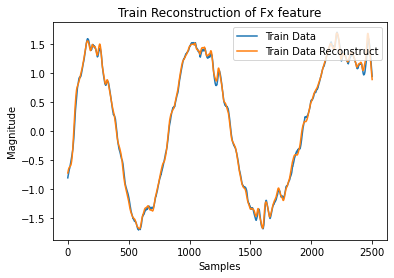

In [ ]:
val = 0

plt.figure()
plt.title(f'Train Reconstruction of {feature_list[val]} feature')
plt.plot(x_train[:2500,0,val],label='Train Data')
plt.plot(x_train_pred[:2500,0,val],label='Train Data Reconstruct')
plt.xlabel('Samples')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.show()

In [ ]:
x_test_pred = model.predict(x_valid)
test_mae_loss = np.mean(np.abs(x_test_pred - x_valid), axis=1)

1117/1117 [==============================] - 4s 4ms/step


In [ ]:
x_valid.shape

(35729, 50, 5)

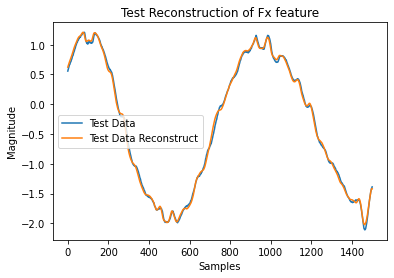

In [ ]:
val = 0

plt.figure()
plt.title(f'Test Reconstruction of {feature_list[val]} feature')
plt.plot(x_valid[1000:2500,0,val],label='Test Data')
plt.plot(x_test_pred[1000:2500,0,val],label='Test Data Reconstruct')
plt.xlabel('Samples')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

## 6. Testing on test data (including anomalies) 

In [ ]:
# testing_indecies = [1, 2, 5, 6, 7, 11, 17, 32, 33, 36, 82, 85, 102, 105, 106, 107, 108, 115, 122, 126]
testing_indecies = [1, 2, 5, 6, 7, 11, 17, 27, 32, 33, 36, 51, 56, 61, 64, 65, 67, 70, 71, 77, 82, 85, 102, 105, 106, 107, 108, 115, 122, 126]
print(len(testing_indecies))

30


### Loop testing

In [ ]:
def sorted_repeated_values(arr, N):
    # Use the numpy unique method to get the unique values and their frequency
    unique, counts = np.unique(arr, return_counts=True)
    
    # Find the values that are repeated at least N times
    repeated = unique[counts >= N]
    
    # Sort the repeated values and return them
    return np.sort(repeated)

In [ ]:
def circle_check(peg_x,peg_y):
    hole_x = -0.1384
    hole_y = -0.5078
    error = np.sqrt((peg_x - hole_x) ** 2 + (peg_y - hole_y) ** 2)
    print(error)
    return error

In [ ]:
dt = 1/125
time_sec = 5
index_cut = int(time_sec/dt)
majority_errors = []
single_errors = []
feature_list = ['Fx','Fy','Fz','Mx','My']

for i in testing_indecies: 

    file_name = "/content/drive/MyDrive/thesis_training/testing/ep{}.csv".format(i)
    
    df_original = pd.read_csv(file_name)
    # cut first 4 sec
    df_original = df_original.drop(range(index_cut)).reset_index(drop=True)
    one_occurace = np.where(df_original.Case == 1)[0]
    print('#######################')
    print(file_name)
    print('#######################')
    print('One Occurance')
    print(one_occurace)
    # reformat test set to sequence
    df_test = df_original[feature_list]

    if use_new_features:
      # mod_features = ["Fxy", "theta_Fxy", "Fz", "Mxy", "theta_Mxy"]
      print('Using new features')
      df_test = new_features(df_test)
    
    if preprocess:
        df_test = df_test.rolling(window).mean()
        # due to the moving average we the first (window-1) rows become NaN so we remove them
        df_test = df_test.loc[window-1:]
        # names = df_test.columns
        # df_test[names] = scaler.transform(df_test[names])
        # print('Data Normalized')
    
    df_test = np.expand_dims(df_test, axis=1)
    x_test = to_sequence(df_test, timesteps=TIMESTEP)
    
    # Get test MAE loss.
    x_test_pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

    #using individual threshold
    anomalies_list = []
    anomalies_idx_list = []
    for i in range(test_mae_loss.shape[1]):
        temp_anomaly = (test_mae_loss[:,i] > thresholds[i]).tolist()
        anomalies_list.append(temp_anomaly)
        anomalies_idx_list.append(np.where(temp_anomaly)[0])

    all_indexes = np.concatenate(anomalies_idx_list)
    
    # finding earliest detection of anomaly for each feature separately
    smallest_idx_list = []
    for i in range(test_mae_loss.shape[1]):
        if anomalies_idx_list[i].size <= 0:
            continue
        else: 
            min_index = min(anomalies_idx_list[i])
            smallest_idx_list.append(min_index)
    if smallest_idx_list:
        smallest_idx = min(smallest_idx_list)
        print('Smallest index: ',smallest_idx)
        peg_x = df_original.x.loc[smallest_idx]
        peg_y = df_original.y.loc[smallest_idx]
        single_error = circle_check(peg_x,peg_y)
    else:
        print('All arrays are empty')  
        single_error = 0
        
    single_errors.append(single_error)

    print('-----Majority index---------')
    majority_index = sorted_repeated_values(all_indexes, 2)
    if any(majority_index):
        print(majority_index)
        start = min(majority_index)
        end = max(majority_index)

        peg_x = df_original.x.loc[start]
        peg_y = df_original.y.loc[start]
        majority_error = circle_check(peg_x,peg_y)
    else:
        print('Empty')
        majority_error = 0
        
    majority_errors.append(majority_error)

#######################
/content/drive/MyDrive/thesis_training/testing/ep1.csv
#######################
One Occurance
[3526 3528 3529 3530 3531 3532 3533 3534 3535 3536 3537 3538 3539 3540
 3541 3542 3543 3544 3545 3546 3547 3548 3549 3550 3551 3552 3553 3554
 3555 3556 3557 3558 3559 3560 3561 3562 3563 3564 3565 3566 3567 3568
 3569 3570 3571 3572 3573 3574 3575 3576 3577 3578 3579 3580 3581 3582
 3583 3584 3585 3586 3587 3588 3589 3590 3591 3592 3593 3594 3595 3596
 3597 3598 3599 3600 3601 3602 5261 5262 5263 5264 5265 5266 5267 5268
 5269 5270 5271 5272 5273 5274 5275 5276 5277 5278 5279 5280 5281 5282
 5283 5284 5285 5286 5287 5288 5289 5290 5291]
163/163 [==============================] - 1s 5ms/step
Smallest index:  3531
0.000744496165785735
-----Majority index---------
[3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545 3546 3547
 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561
 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573 3574 3575

## 7. Testing one by one

In [ ]:
dt = 1/125
time_sec = 5
index_cut = int(time_sec/dt)
print(index_cut)
# verify 
print(df_original.t.iloc[index_cut]-df_original.t.iloc[0])

625
5.000154495239256


In [ ]:
# pick one of the time series that include the anomaly for testing 
# df_testing_data = pd.read_csv('/content/drive/MyDrive/thesis_training/testing/ep1.csv')
df_testing_data = pd.read_csv('/content/drive/MyDrive/thesis_training/spiral6/ep4.csv')

# df_testing_data = pd.read_csv('/content/drive/MyDrive/unseen_data/ep12.csv')
# df_original = pd.read_csv('./robotdatacollection3_part2/ep1.csv')
# df_original = df_original.rolling(50, min_periods=1).mean()
# df_original = df_original.iloc[400:]

In [ ]:
df_testing_data = df_testing_data.drop(range(index_cut)).reset_index(drop=True)

In [ ]:
one_occurace = np.where(df_testing_data.Case == 1)[0]
print(one_occurace)
feature_list = ['Fx','Fy','Fz','Mx','My']


[2809 2810 2811 2812 2813 2814 2815 2816 2817 2818 2819 2820 2821 2822
 2823 2824 2825 2826 2827 2828 2829 2830 2831 2832 2833 2834 2835 2836
 2837 2838 2839 2840 2841 2842 2843 2844 2845 2846 2847 2848 2849 2850
 2851 2852 2853 2854 2855 2856 2857 2858 2859 2860 2861 2862 2863 2864
 2865 2866 2867 2868 2869 2870 2871 2872 2873 2874 2875 2876 2877 2878
 2879 2880 2881 2882 2883 2884 2885 2886 2889 4407 4408 4409 4410 4411
 4412 4413 4414 4415 4416 4417 4418 4419 4420 4421 4422 4423 4424 4425
 4426 4427 4428 4429 4430 4431 4432 4433 4434 4435 4436]


In [ ]:
df_testing_data.shape

(4437, 18)

In [ ]:
def plot_with_labels(df, name, show_label):
    plt.figure(figsize=(10,4))
    plt.title(name)
    plt.plot(df.t, df[name])
    if show_label:
        for i in one_occurace:
            plt.scatter(df.t.loc[i], df[name].loc[i],marker='*', color='red', zorder=12, alpha=0.2)
    plt.grid()
    plt.show()

def plot_vs_time(df, name):
    plt.figure(figsize=(10,4))
    plt.title(name)
    plt.plot(df.t, df[name])
    plt.grid()
    plt.show()

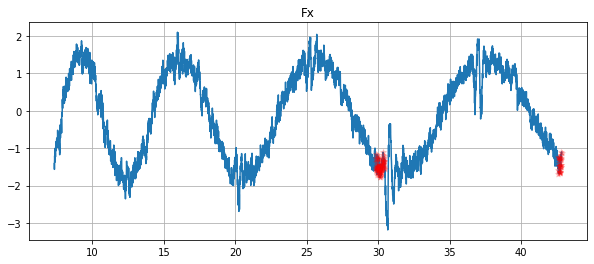

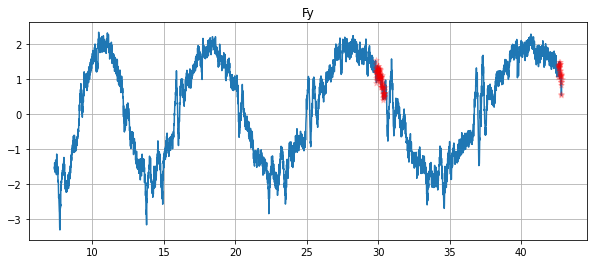

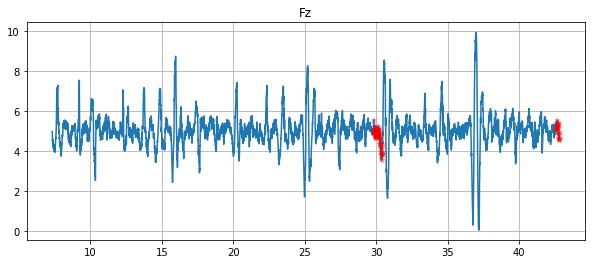

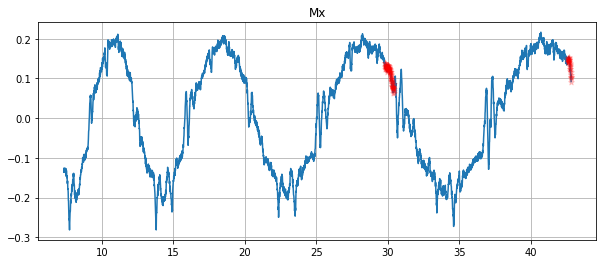

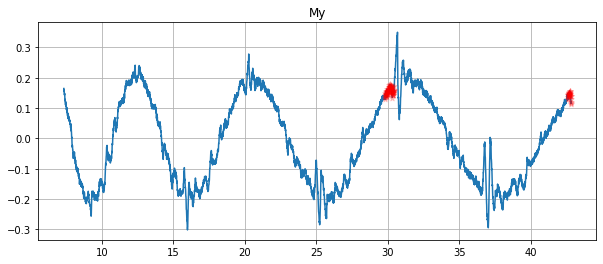

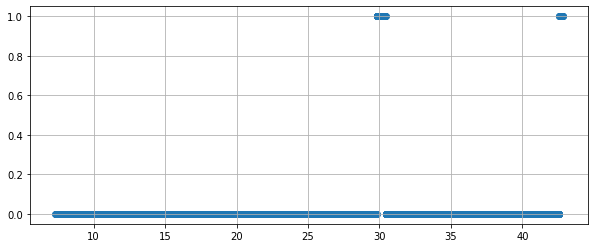

In [ ]:
# we will use the original dataset which contains anomaly for testing
for f in feature_list:
    plot_with_labels(df=df_testing_data,name=f,show_label=True)
    
plt.figure(figsize=(10,4))
plt.scatter(df_testing_data.t, df_testing_data.Case)
plt.grid()

### 7.1. Preparing Test Set

In [ ]:
df_test = df_testing_data[feature_list]

In [ ]:
df_testing_data.shape

(4437, 18)

In [ ]:
df_test_plot = df_test
if use_new_features:
  df_test = new_features(df_test)
  df_test_plot = df_test

In [ ]:
df_test.shape

(4437, 5)

In [ ]:
df_test.describe()

,Fxy,theta_Fxy,Fz,Mxy,theta_Mxy
count,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000
mean,1.753740,0.109064,4.996889,0.193190,-0.138499
std,0.361149,1.770979,0.871887,0.029556,1.746810
min,0.076344,-3.138807,0.046755,0.005397,-3.138261
25%,1.531658,-1.465531,4.649839,0.179464,-1.446911
50%,1.780010,0.488655,4.986398,0.193448,-0.286409
75%,1.984022,1.676232,5.315506,0.207143,1.239922
max,3.456978,3.138069,9.921338,0.353735,3.140022


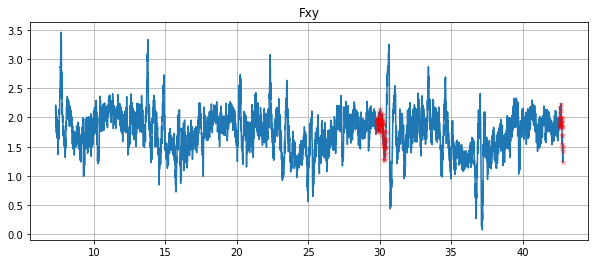

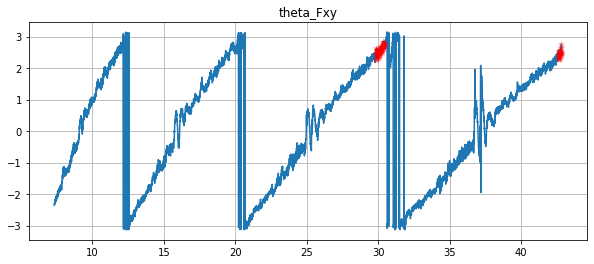

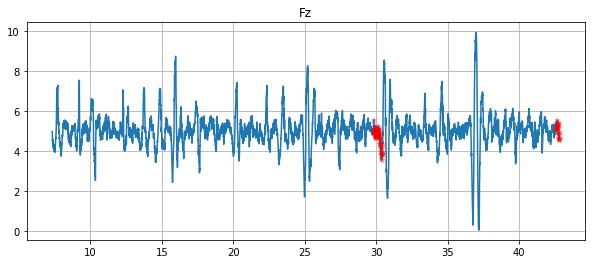

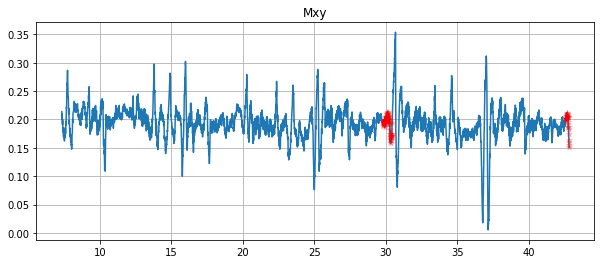

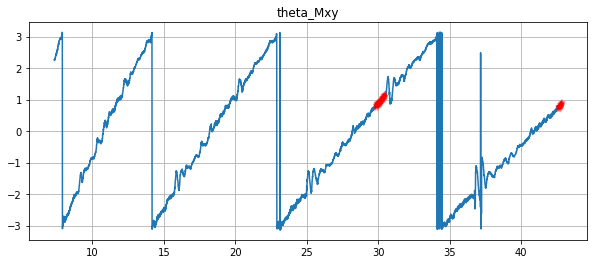

In [ ]:
if use_new_features:
  for f in mod_features:
    plt.figure(figsize=(10,4))
    plt.title(f)
    plt.plot(df_testing_data.t,df_test[f])
    for i in one_occurace:
      plt.scatter(df_testing_data.t.loc[i], df_test[f].loc[i],marker='*', color='red', zorder=12, alpha=0.2)
    plt.grid()
    plt.show()

In [ ]:
if preprocess:
    df_test = df_test.rolling(window).mean()
    # due to the moving average we the first (window-1) rows become NaN so we remove them
    df_test = df_test.loc[window-1:]
    # names = df_test.columns
    # df_test[names] = scaler.transform(df_test[names])
    # display(df_test.describe())
    # print('Data Normalized')

df_test_window_db = df_test

In [ ]:
print(df_test.shape)
df_test = np.expand_dims(df_test, axis=1)
print(df_test.shape)

(4398, 5)
(4398, 1, 5)


In [ ]:
# create sequence of the test dataset
x_test = to_sequence(df_test, timesteps=TIMESTEP)
print(f"""Shape of the datasets:
    original test data = {df_test.shape}
    sequenced test data = {x_test.shape}""")

Shape of the datasets:
    original test data = (4398, 1, 5)
    sequenced test data = (4348, 50, 5)


### 7.2. Calculating MAE Loss on the Test Set

In [ ]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

136/136 [==============================] - 1s 4ms/step


In [ ]:
if use_new_features:
  feature_list = mod_features

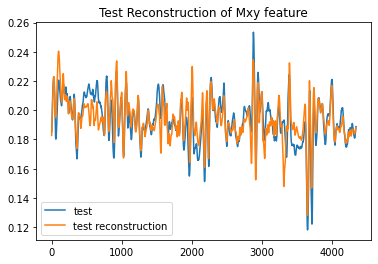

In [ ]:
val = 3
plt.figure()
plt.title(f'Test Reconstruction of {feature_list[val]} feature')
plt.plot(x_test[:,1,val],label='test')
plt.plot(x_test_pred[:,1,val],label='test reconstruction')
plt.legend()
plt.show()

#### Plotting Train and Test Loss on same plots for each feature (experimenting) 

In [ ]:
thresholds

[0.14266792305164488,
 0.25511093499910503,
 0.27209656676361876,
 0.05406502523990801,
 0.5062460031645604]

In [ ]:
threshold_max = max(thresholds)

In [ ]:
train_mae_loss.shape

(321955, 5)

In [ ]:
def normalize_histogram(error,f, bins_val=50):
  counts, bins = np.histogram(error[:,f], bins=bins_val)
  bin_widths = np.diff(bins)
  normalized_counts = counts / (len(error) * bin_widths)
  return bins, normalized_counts, bin_widths

In [ ]:
train_mae_loss.shape

(321955, 5)

In [ ]:
test_mae_loss.shape

(4348, 5)

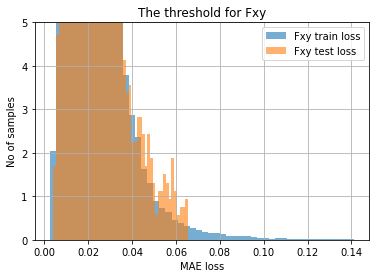

In [ ]:
f = 0
bins_train, normalized_counts_train,bin_widths_train = normalize_histogram(train_mae_loss,f, 50)
bins_test, normalized_counts_test,bin_widths_test = normalize_histogram(test_mae_loss,f, 50)


plt.title(f"The threshold for {feature_list[f]}")
plt.bar(bins_train[:-1], normalized_counts_train, width=bin_widths_train, label=f"{feature_list[f]} train loss",alpha=0.6)
plt.bar(bins_test[:-1], normalized_counts_test, width=bin_widths_test, label=f"{feature_list[f]} test loss",alpha=0.6)
# plt.axvline(x=thresholds[f], linestyle='-',color='r',label='threshold')
plt.xlabel("MAE loss")
plt.ylabel("No of samples")
# plt.xlim([-0.01, 0.4])
plt.ylim(0,5)
plt.grid()
plt.legend()
plt.show()



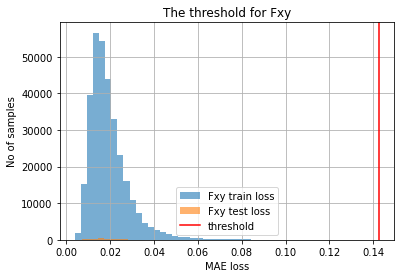

In [ ]:
# for loss in range(len(feature_list)):
f = 0
plt.title(f"The threshold for {feature_list[f]}")
plt.hist(train_mae_loss[:,f], bins=50, label=f"{feature_list[f]} train loss",alpha=0.6)
plt.hist(test_mae_loss[:,f], bins=50, label=f"{feature_list[f]} test loss",alpha=0.6)
plt.axvline(x=thresholds[f], linestyle='-',color='r',label='threshold')
# plt.axvline(x=threshold_max, linestyle='-',color='b',label='threshold')
plt.xlabel("MAE loss")
plt.ylabel("No of samples")
# plt.xlim([-0.01, 1.4])
# plt.ylim(0,0)
plt.grid()
plt.legend()
plt.show()


REMINDER
* `reconstruction_loss < threshold `: **normal**
* `reconstruction_loss > threshold `: **anomaly**

### Using Threshold (global/local) 

In [ ]:
thresholds

[0.14266792305164488,
 0.25511093499910503,
 0.27209656676361876,
 0.05406502523990801,
 0.5062460031645604]

In [ ]:
method = 'local'
#using individual threshold
anomalies_list = []
anomalies_idx_list = []
for i in range(test_mae_loss.shape[1]):
    # temp_anomaly = (test_mae_loss[:,i] > threshold_max).tolist()
    temp_anomaly = (test_mae_loss[:,i] > thresholds[i]).tolist()

    anomalies_list.append(temp_anomaly)
    anomalies_idx_list.append(np.where(temp_anomaly)[0])

    print(f"Number of anomaly samples for #{i+1} which is {feature_list[i]}: ", np.sum(temp_anomaly))
    print("Indices of anomaly samples: ", np.where(temp_anomaly)[0])
    print()
    

Number of anomaly samples for #1 which is Fxy:  0
Indices of anomaly samples:  []

Number of anomaly samples for #2 which is theta_Fxy:  0
Indices of anomaly samples:  []

Number of anomaly samples for #3 which is Fz:  0
Indices of anomaly samples:  []

Number of anomaly samples for #4 which is Mxy:  0
Indices of anomaly samples:  []

Number of anomaly samples for #5 which is theta_Mxy:  0
Indices of anomaly samples:  []



In [ ]:
all_indexes = np.concatenate(anomalies_idx_list)

### Display detected anomalies per feature

In [ ]:
df_test_plot.head()

,Fxy,theta_Fxy,Fz,Mxy,theta_Mxy
0,2.078182,-2.318342,4.962431,0.213647,2.262114
1,2.211110,-2.358758,4.809526,0.201850,2.271957
2,2.086023,-2.279720,4.507804,0.200929,2.245302
3,1.842164,-2.283761,4.438084,0.210175,2.266049
4,1.980341,-2.314148,4.588167,0.200820,2.306239


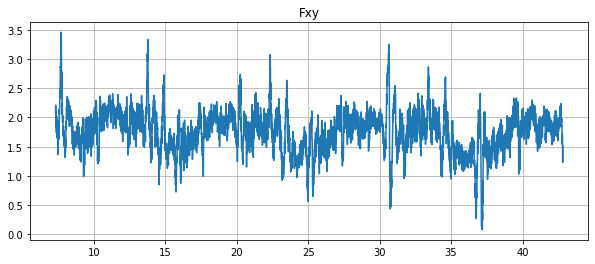

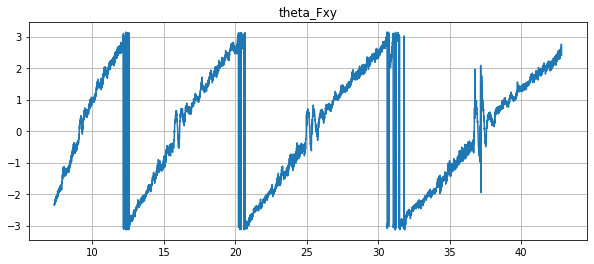

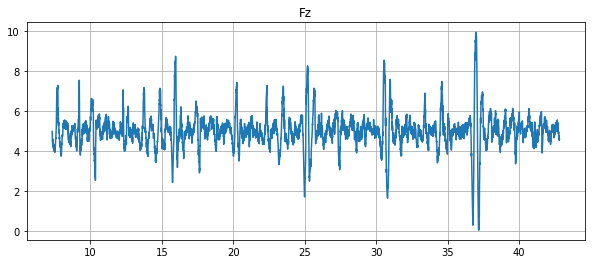

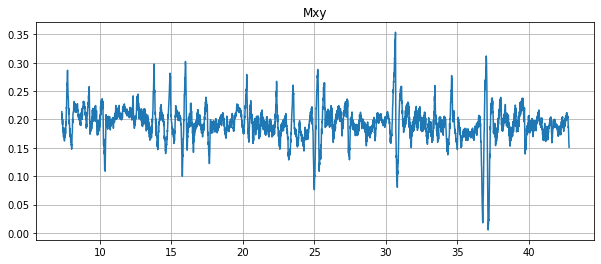

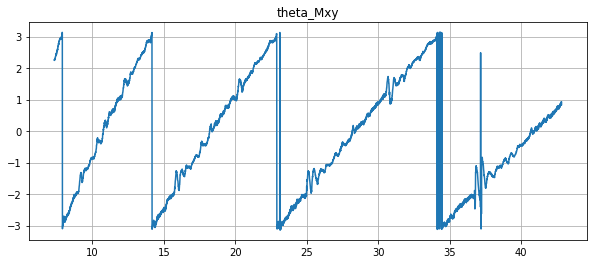

In [ ]:
for i in range(len(feature_list)):
    plt.figure(figsize=(10,4))
    name = str(feature_list[i])
    plt.title(name)
    plt.plot(df_testing_data.t, df_test_plot[name])
    for k in anomalies_idx_list[i]:
        plt.scatter(df_testing_data.t.loc[k], df_test_plot[name].loc[k],marker='*', color='red', zorder=12, alpha=0.4)
    plt.grid()
    plt.show()


### Some exploration of the values

#### 1. Chosing earliest detection in any of the features

In [ ]:
# finding earliest detection of anomaly for each feature separately
smallest_idx = 0
smallest_idx_list = []
for i in range(test_mae_loss.shape[1]):
    if anomalies_idx_list[i].size <= 0:
        print(f"Smallest index for #{i+1} doesnt exist, as the array is empty!")    
    else: 
        min_index = min(anomalies_idx_list[i])
        print(f"Smallest index for #{i+1} is {min_index}")
        smallest_idx_list.append(min_index)
    
print()
if smallest_idx_list:
    smallest_idx = min(smallest_idx_list)
else:
    print('All arrays are empty')
print('Resulting smallest index: ',smallest_idx)

Smallest index for #1 doesnt exist, as the array is empty!
Smallest index for #2 doesnt exist, as the array is empty!
Smallest index for #3 doesnt exist, as the array is empty!
Smallest index for #4 doesnt exist, as the array is empty!
Smallest index for #5 doesnt exist, as the array is empty!

All arrays are empty
Resulting smallest index:  0


In [ ]:
def sorted_repeated_values(arr, N):
    # Use the numpy unique method to get the unique values and their frequency
    unique, counts = np.unique(arr, return_counts=True)
    
    # Find the values that are repeated at least N times
    repeated = unique[counts >= N]
    
    # Sort the repeated values and return them
    return np.sort(repeated)

def circle_check(peg_x,peg_y):
  
    hole_x = -0.1384
    hole_y = -0.5078
    
    error = np.sqrt((peg_x - hole_x) ** 2 + (peg_y - hole_y) ** 2)
    return error

#### 3. Chosing earliest detection thats shared among majority of the features i.e. if feature number = 3, then at least 2 share

In [ ]:
import math

In [ ]:
n_features = len(feature_list)
# round up to the nearest whole number to define majority
n_majority = math.ceil(n_features/2)
n_majority = 2
print('Majority =',n_majority)

Majority = 2


In [ ]:
majority_index = sorted_repeated_values(all_indexes, 2)

In [ ]:
majority_index

array([3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3774, 3775,
       3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786,
       3787, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854,
       3855, 3856, 3857])

## Big Question: How we define anomaly?
1. We can be conservative and first diagonsis as anomaly in one of features results in classification as anomaly for all the features. This approach is done based on global threshold.
2. We can also compare index of each feature which was classified as anomaly to the global threshold, collect the indexes, and only indexes that appear more often are anomalies

## Approach #1 - based on smallest idx
Issue happens when 1 feature detects anomaly earlier then other 2 features. In that case pre-mature anomaly is detected. 

In [ ]:
smallest_idx

3704

In [ ]:
peg_x = df_testing_data.x.loc[smallest_idx]
peg_y = df_testing_data.y.loc[smallest_idx]

circle_check(peg_x,peg_y)

0.00659289008251752

In [ ]:
feature_list

['Fx', 'Fy', 'Fz', 'Mx', 'My']

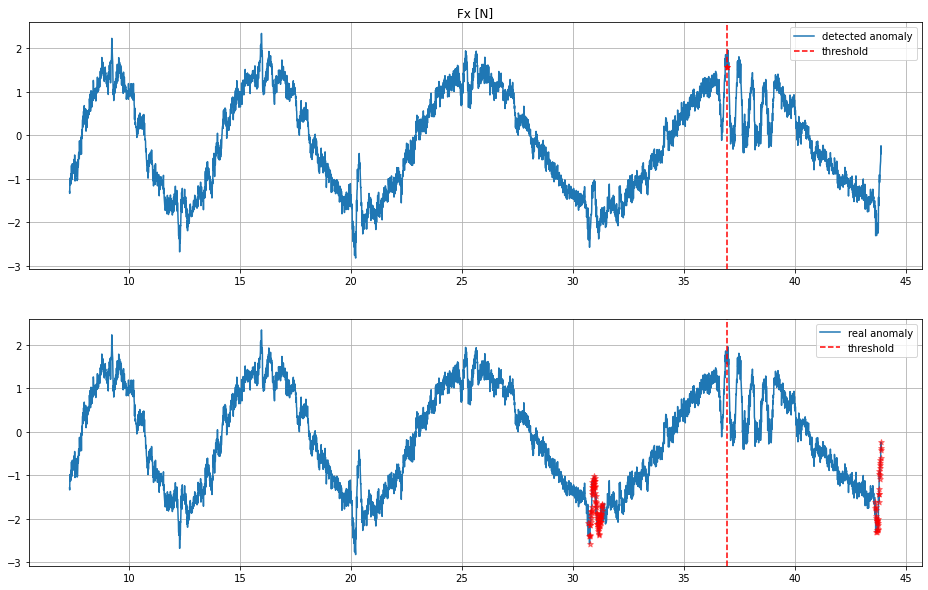

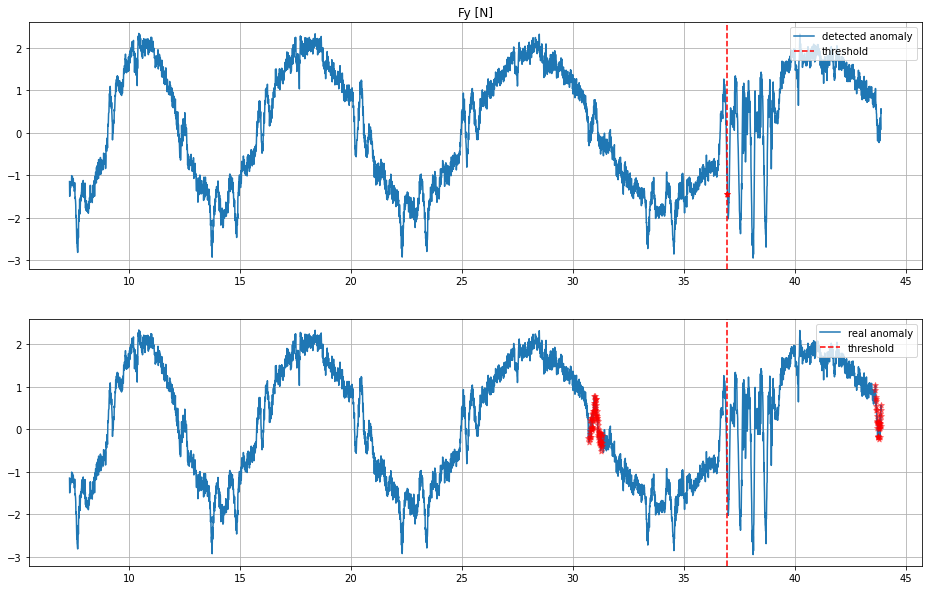

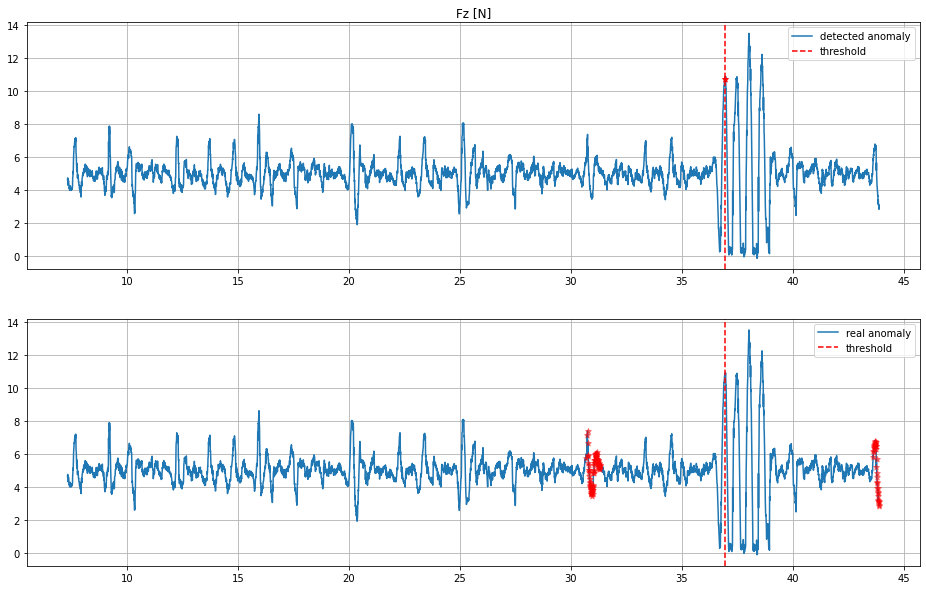

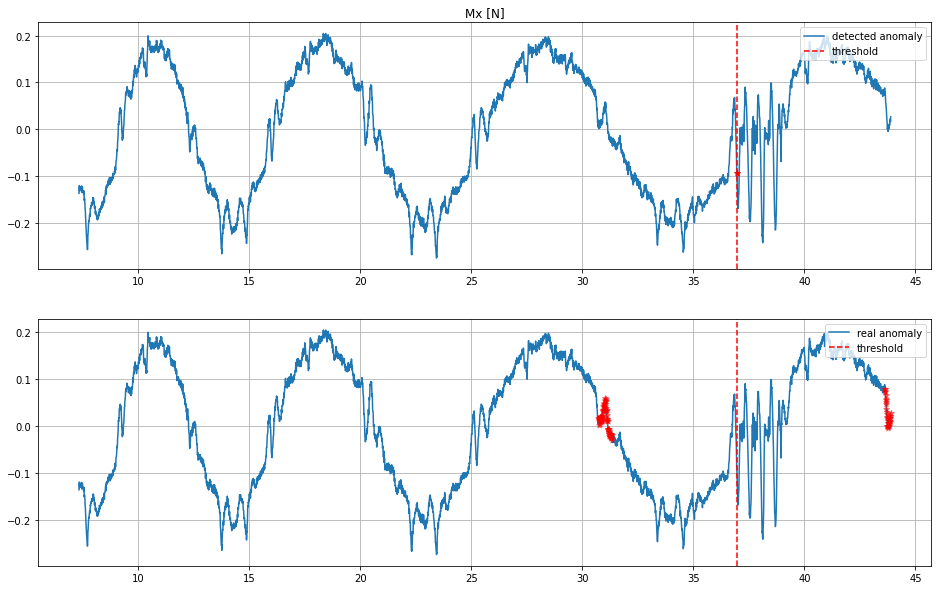

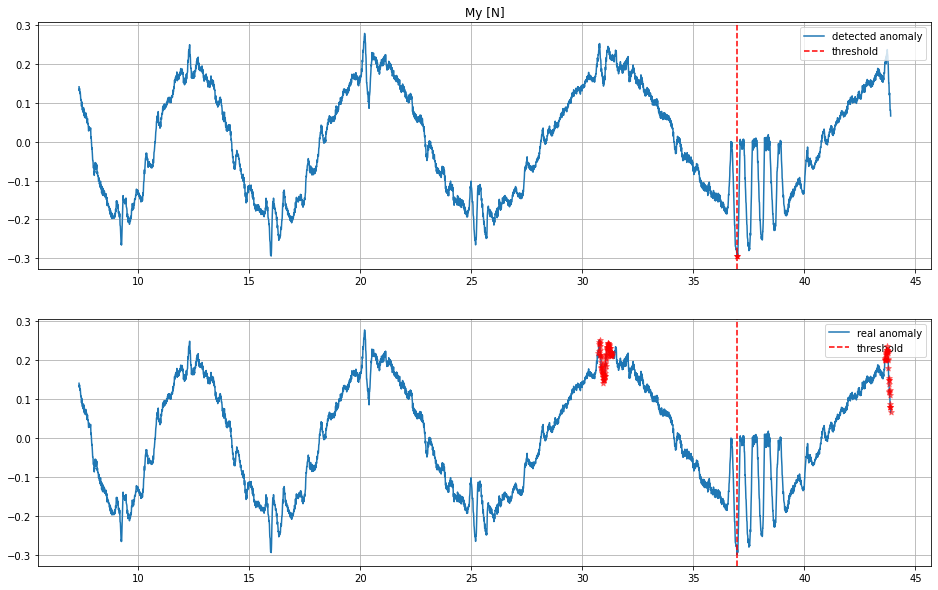

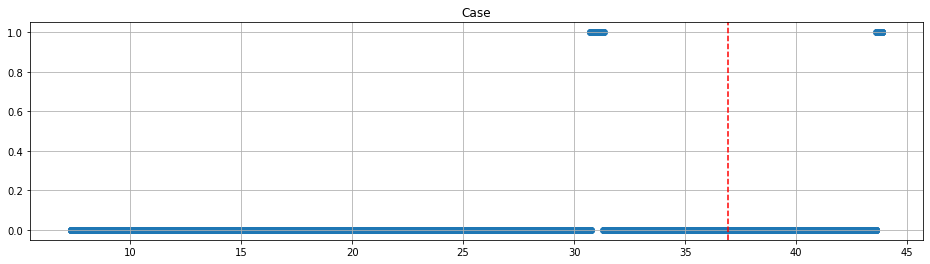

In [ ]:
for feature in feature_list:
    fig, axs = plt.subplots(2,1,figsize=(16,10))
#     smallest_idx=4620
    axs[0].plot(df_testing_data.t, df_test_plot[feature],label='detected anomaly')
    axs[0].scatter(df_testing_data.t.loc[smallest_idx], df_test_plot[feature].loc[smallest_idx],
                   marker='*', color='red', zorder=12, alpha=1)
    axs[0].axvline(x=df_testing_data.t.loc[smallest_idx], linestyle='--',color='r',label='threshold')

    axs[0].legend(loc='upper right')
    axs[0].grid()
    axs[0].set_title(f'{feature} [N]')

    axs[1].plot(df_testing_data.t, df_test_plot[feature],label='real anomaly')
    axs[1].axvline(x=df_testing_data.t.loc[smallest_idx], linestyle='--',color='r',label='threshold')
    for i in one_occurace:
        axs[1].scatter(df_testing_data.t.loc[i], df_test_plot[feature].loc[i],
                       marker='*', color='red', zorder=12, alpha=0.5)
    axs[1].legend(loc='upper right')
    axs[1].grid()
    plt.show()
    
plt.figure(figsize=(16,4))
plt.title('Case')
plt.scatter(df_testing_data.t, df_testing_data.Case)
plt.axvline(x=df_testing_data.t.loc[smallest_idx], linestyle='--',color='r',label='threshold')
plt.grid()
plt.show()

## Approach #3 - use index that shared across at least the majority of the features
In case of using 3 features, index has to be shared at least among the 2 of them.

In [ ]:
print(majority_index)
start = min(majority_index)
end = max(majority_index)

[3706 3707 3708 3709 3710 3711 3712 3713 3714 3774 3775 3776 3777 3778
 3779 3780 3781 3782 3783 3784 3785 3786 3787 3845 3846 3847 3848 3849
 3850 3851 3852 3853 3854 3855 3856 3857]


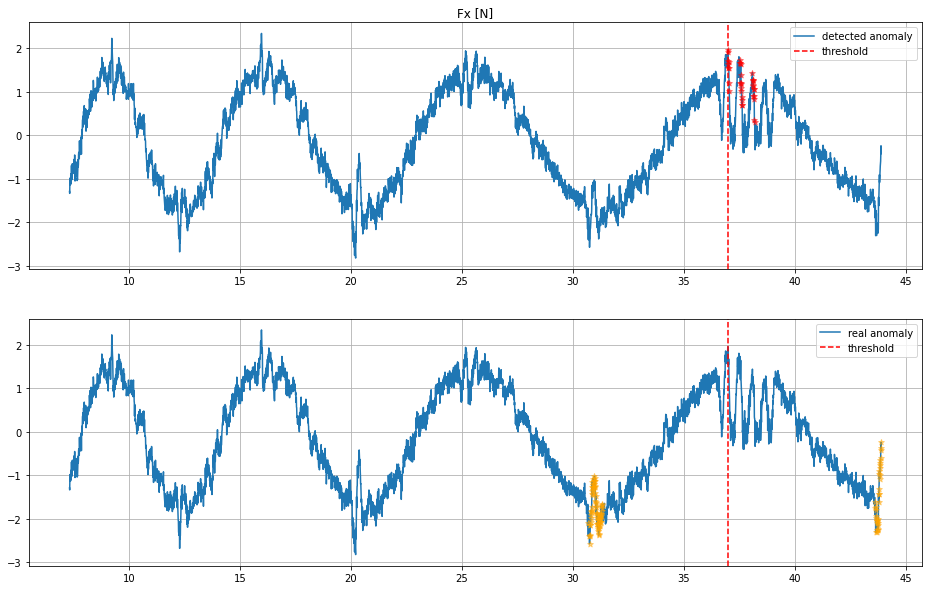

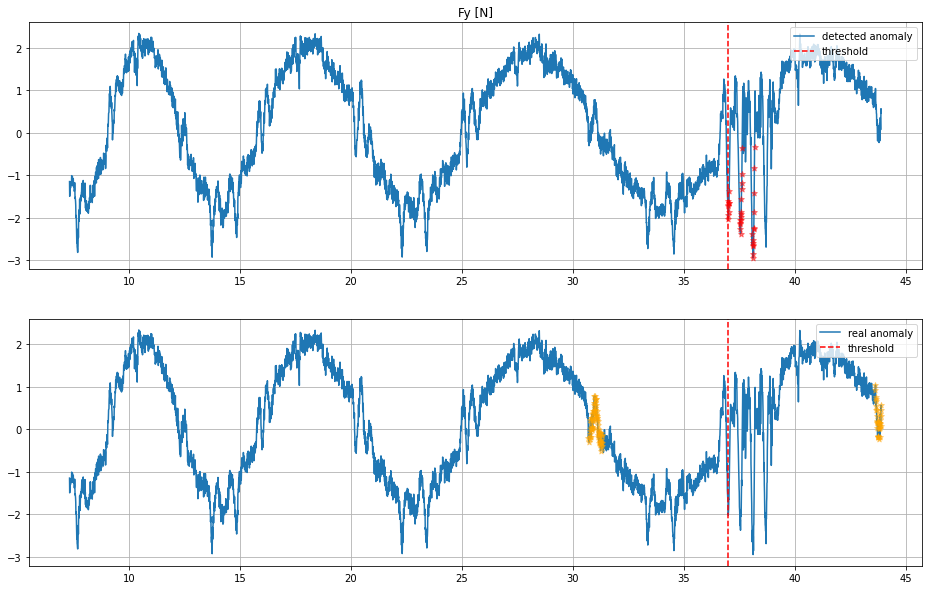

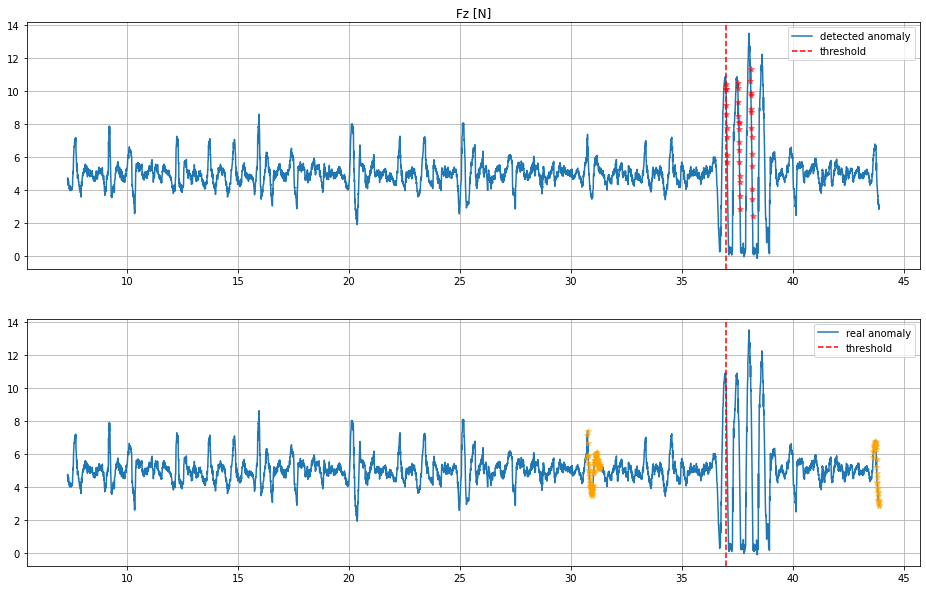

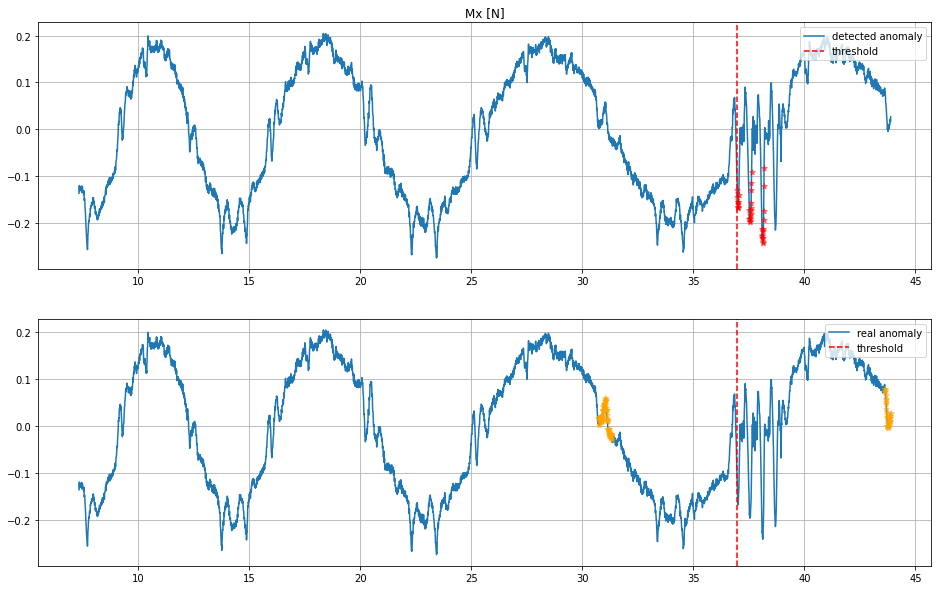

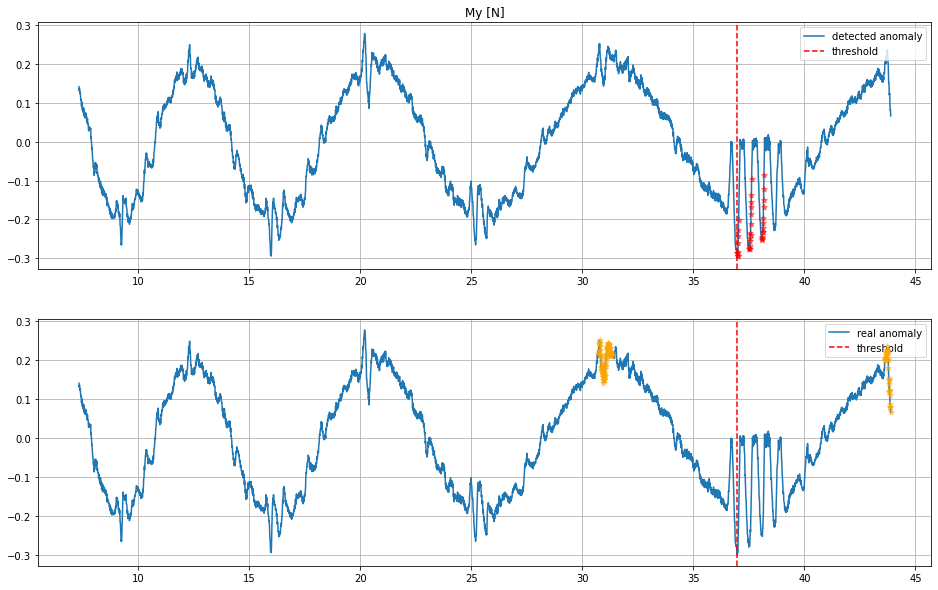

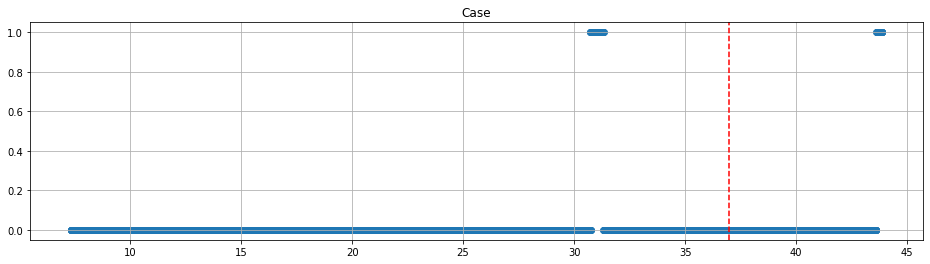

In [ ]:
for feature in feature_list:
    fig, axs = plt.subplots(2,1,figsize=(16,10))
    axs[0].plot(df_testing_data.t, df_test_plot[feature],label='detected anomaly')
    axs[0].axvline(x=df_testing_data.t.loc[start], linestyle='--',color='r',label='threshold')
    for i in majority_index:
        axs[0].scatter(df_testing_data.t.loc[i], df_test_plot[feature].loc[i],
                       marker='*', color='red', zorder=12, alpha=0.5)
    axs[0].legend(loc='upper right')
    axs[0].grid()
    axs[0].set_title(f'{feature} [N]')

    axs[1].plot(df_testing_data.t, df_test_plot[feature],label='real anomaly')
    axs[1].axvline(x=df_testing_data.t.loc[start], linestyle='--',color='r',label='threshold')
    for i in one_occurace:
        axs[1].scatter(df_testing_data.t.loc[i], df_test_plot[feature].loc[i],
                       marker='*', color='orange', zorder=12, alpha=0.5)
    axs[1].legend(loc='upper right')
    axs[1].grid()
    plt.show()
    
plt.figure(figsize=(16,4))
plt.title('Case')
plt.scatter(df_testing_data.t, df_testing_data.Case)
plt.axvline(x=df_testing_data.t.loc[start], linestyle='--',color='r',label='threshold')
plt.grid()
plt.show()

In [ ]:
start 

3706

In [ ]:
peg_x = df_testing_data.x.loc[start]
peg_y = df_testing_data.y.loc[start]

circle_check(peg_x,peg_y)

0.006616085179376932

In [ ]:
one_occurace

## Confusion matrix
We need `y_true` and `y_pred`
Assume:
* 1: anomaly
* 2 non-anomaly

### 1. Y_pred

In [ ]:
y_true = df_testing_data.Case.values

### 2. Y_pred

In [ ]:
all_indexes = df_testing_data.index.to_numpy()

In [ ]:
mask = np.isin(all_indexes, majority_index)
y_pred = np.full_like(all_indexes, False)
y_pred[mask] = True

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_true, y_true)

array([[4833,    0],
       [   0,   42]])

In [ ]:
confusion_matrix(y_true, y_pred)

array([[4762,   71],
       [  42,    0]])